## TDS 2024 - Instructor Guide

#### The predictive task
The task is to predict (or estimate how likely) whether a claim will be filed for a given yearly policy (binary classification).  
The dataset contains a list of renters/home yearly policies in the US. Each yearly policy is marked whether a claim has been filed (`filed_claim` column).  
[This](#Data-dictionary) section provides detailed descriptions for each field in the dataset.

#### How the dataset challenges have been addressed
- **Imbalanced**
    - Stratified split - keep the positive/negative label ratio in train/test folds ([here](#Split-train/test)) and in cross-validation splits ([here](#Cross-Validation-Evaluation)).
    - Model class weight - inflate the weight of the positive classes ([here](#Model)).
    - Use `ROC AUC` metric because it is less sensitive to class distribution.
- **Small**
    - Binning of numerical features - reduces sensitivity to noise and variability.
    - Model regularization to reduce the chance of overfitting ([here](#Model)).
- **Missing values**
    - All the details here: [Missing Data Analysis - Summary and Imputation](#Summary-and-Imputation).
- **High cardinality**
    - Enrich the policies zip code with free postal code dataset ([here](#Enrich-Postal-Codes)). Then, introduce new features: `is_rural`, `is_urban`, and `nearest_policies_claim_ratio`.

#### Don't miss
- [Feature engineering: claim ratio of the nearest policies](#Claim-ratio-of-nearest-policies-\(by-zipcode-lat/lng\))
- [Model prediction uplift](#Model-Prediction-Uplift)

# Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

pd.options.mode.copy_on_write = True

%matplotlib inline

# Read Dataset

In [2]:
%%bash
mkdir -p data
if [ ! -f data/insurance_policy_risk.csv ]; then
    wget https://drive.usercontent.google.com/u/0/uc?id=1rBuO32aUjKyR0wPgGOqO1AjcjZBuFj9Z -O data/insurance_policy_risk.csv
else
    echo "File 'data/insurance_policy_risk.csv' already exists. Skipping download."
fi

File 'data/insurance_policy_risk.csv' already exists. Skipping download.


In [3]:
df_policies = pd.read_csv('data/insurance_policy_risk.csv', dtype={'policy_id': str, 'user_id': str})
df_policies.head()

,policy_id,state,postal_code,product,user_id,square_ft,has_fire_alarm,has_burglar_alarm,portable_electronics,coast,fire_housing_proximity,previous_policies,user_age,card_type,filed_claim
0,2492008697672104938,NM,87043,ho4,-9160046293075786063,NaN,True,True,0.0,NaN,5,0,39.0,credit,False
1,886075317023782670,WI,53715,ho4,-8929003830875133003,NaN,True,False,1.0,30.0,1,0,19.0,debit,False
2,5527292118261850881,WI,53211,ho4,-9015977226434470133,NaN,True,False,1.0,1.0,1,0,20.0,debit,True
3,6453397743269682220,NM,88012,ho4,-9060026899039337265,NaN,True,True,1.0,NaN,1,0,33.0,debit,False
4,-8836394806705049849,AR,72116,ho4,-8801719090048493625,NaN,False,False,1.0,NaN,1,0,20.0,debit,False


In [4]:
df_policies.describe()

,postal_code,square_ft,portable_electronics,coast,previous_policies,user_age
count,12397.000000,279.000000,11990.000000,11242.000000,12397.000000,12315.000000
mean,62576.877309,1457.498208,0.336364,17.839619,0.237961,31.085668
std,32553.186912,728.877297,0.472485,12.128988,0.527252,10.000254
min,2840.000000,100.000000,0.000000,0.000000,0.000000,17.000000
25%,30084.000000,850.000000,0.000000,4.000000,0.000000,24.000000
50%,77006.000000,1350.000000,0.000000,20.000000,0.000000,29.000000
75%,91367.000000,1907.500000,1.000000,30.000000,0.000000,35.000000
max,97702.000000,4478.000000,1.000000,30.000000,7.000000,112.000000


#### Data dictionary

- `policy_id` - unique identifier of a yearly policy.
- `user_id` - unique identifier of a user. More than one policy might be associated with the same user.
- `state` - the insured US state. Categorical.
- `postal_code` - the insured postal code. Categorical (some state/county information can be extracted). High Cardinality.
- `product` - the policy type: ho4-renters / ho3-homeowners / ho6-homeowners (condo). Categorical.
- `square_ft` - the insured property size. Numeric. 97.7% missing values.
- `has_fire_alarm` - whether a fire alarm exists. Boolean.
- `has_burglar_alarm` - whether a burglar alarm exists. Boolean.
- `portable_electronics` - whether portable electronics is insured. Boolean. 3.3% missing values.
- `coast` - Distance from the coastline. Numeric. 9.3% missing values.
- `fire_housing_proximity` - Proximity of fire housing. Ordinal.
- `previous_policies` - number of previous policies. Numeric.
- `user_age` - the age of the user in years. Numeric. 0.7% missing values.
- `card_type` - the credit card being used. Categorical. 0.4% missing values.
- `filed_claim` - whether a user filed a claim for this policy. Boolean. Label.

#### Data Cleaning

`fire_housing_proximity` - this field was not resolved to `int` type as expected (not included in `describe` dump).  
There are 15 instances with a character attached to a valid numeric value. It doesn't seem to correlate with anything.   
Removing it to keep the ordinal nature of the field.

In [5]:
df_policies['fire_housing_proximity'] = df_policies['fire_housing_proximity'].str.extract('(\d)').astype(int)

# Enrich Postal Codes

Download a free postal code dataset [[1]](#References) and keep it in `data` folder.  
Enrich the high-cardinality postal code with the following data:
- `zip` - the 5-digit zip code assigned by the U.S. Postal Service
- `lat` - the latitude of the zip code
- `lng` - the longitude of the zip code
- `city` - the official USPS city name
- `population` - an estimate of the zip code's population
- `density` - the estimated population per square kilometer

In [6]:
%%bash
if [ ! -f data/uszips.csv ]; then
    wget https://simplemaps.com/static/data/us-zips/1.84/basic/simplemaps_uszips_basicv1.84.zip -O data/uszips.zip
    unzip data/uszips.zip -d data
else
    echo "File 'data/unzips.csv' already exists. Skipping download."
fi

File 'data/unzips.csv' already exists. Skipping download.


In [7]:
df_uszips = pd.read_csv('data/uszips.csv', index_col='zip', usecols=['zip','lat','lng','city','population','density'])

# Impute missing zip codes with adjusted ones
df_uszips.loc[10270] = df_uszips.loc[10128].copy()
df_uszips.loc[60699] = df_uszips.loc[60607].copy()

df = df_policies.join(df_uszips, on='postal_code', how='inner')

# Verify all postal codes (of the policies) have been resolved
assert len(df) == len(df_policies)

df.head()

,policy_id,state,postal_code,product,user_id,square_ft,has_fire_alarm,has_burglar_alarm,portable_electronics,coast,fire_housing_proximity,previous_policies,user_age,card_type,filed_claim,lat,lng,city,population,density
0,2492008697672104938,NM,87043,ho4,-9160046293075786063,NaN,True,True,0.0,NaN,5,0,39.0,credit,False,35.28978,-106.44418,Placitas,4066.0,14.6
1,886075317023782670,WI,53715,ho4,-8929003830875133003,NaN,True,False,1.0,30.0,1,0,19.0,debit,False,43.06038,-89.39861,Madison,16072.0,4690.5
2,5527292118261850881,WI,53211,ho4,-9015977226434470133,NaN,True,False,1.0,1.0,1,0,20.0,debit,True,43.08308,-87.88485,Milwaukee,34775.0,3386.3
3,6453397743269682220,NM,88012,ho4,-9060026899039337265,NaN,True,True,1.0,NaN,1,0,33.0,debit,False,32.58898,-106.77135,Las Cruces,31800.0,35.2
4,-8836394806705049849,AR,72116,ho4,-8801719090048493625,NaN,False,False,1.0,NaN,1,0,20.0,debit,False,34.80025,-92.24505,North Little Rock,20838.0,1239.5


# Split train/test

1. To prevent data leakage, all samples of the same user are within the same fold.
1. Due to the small number of `True` labels, the label ratio is kept between the folds.
1. The dataset is split before the EDA so any of the decisions will not rely on the data in the test set.

In [8]:
# To create a test dataset with the above directives (user in one fold, keep label ratio):
# Constructing users list with aggregated target (True if one of the user samples is True, otherwise False).
user_ids, labels = zip(
    *[
        (user_id, np.any(user_rows['filed_claim'])) for user_id, user_rows in df.groupby('user_id')
    ]
)

# Split the users (70/30) while keeping the proportion of the labels (stratify).
users_train, users_test = train_test_split(user_ids, test_size=0.3, stratify=labels, random_state=42)

df_train = df[df.user_id.isin(users_train)]
df_test = df[df.user_id.isin(users_test)]

In [9]:
# Validate train/test split.
print(f"Split size: {len(df_train)} + {len(df_test)} = {len(df)}")
print(f"Number of users exist in both groups: {len(set(df_train['user_id']) & set(df_test['user_id']))}")
print("True target ratio in test: {:.1f}%".format(len(df_test[df_test.filed_claim]) / 281 * 100))

Split size: 8661 + 3736 = 12397
Number of users exist in both groups: 0
True target ratio in test: 30.2%


# Exploratory Data Analysis

## product

`97.8%` of the policies are `ho4` (renters).  
Claim ratio of `ho3` (homeowners) and `ho6` (condo) is a little higher, but it is not statistically significant due to the small sample size (pvalue: 0.21).

In [10]:
def create_claimed_contingency_table(field):
    contingency_table = df_train.groupby(field, observed=True).agg(total=('filed_claim', 'count'), claimed=('filed_claim', 'sum'))
    contingency_table['unclaimed'] = contingency_table['total'] - contingency_table['claimed']
    contingency_table['ratio'] = contingency_table['claimed'] / contingency_table['total']
    return contingency_table

In [11]:
product_contingency_table = create_claimed_contingency_table('product')
product_contingency_table

,total,claimed,unclaimed,ratio
product,,,,
ho3,88,3,85,0.034091
ho4,8462,188,8274,0.022217
ho6,111,5,106,0.045045


In [12]:
res = stats.chi2_contingency(product_contingency_table[['claimed','unclaimed']])
res.statistic, res.pvalue

(3.1093500930083353, 0.2112580205205985)

## state

The majority of the policies are sold in `CA`, `TX`, and `NY`.  
There is no statistically significant claim ratio difference between the different states.

In [13]:
state_contingency_table = create_claimed_contingency_table('state')
state_contingency_table = state_contingency_table.sort_values('total', ascending=False).head(7)
state_contingency_table

,total,claimed,unclaimed,ratio
state,,,,
CA,2643,64,2579,0.024215
TX,2328,41,2287,0.017612
NY,1525,35,1490,0.022951
IL,587,12,575,0.020443
NJ,301,8,293,0.026578
GA,281,9,272,0.032028
OH,210,7,203,0.033333


In [14]:

res = stats.chi2_contingency(state_contingency_table[['claimed','unclaimed']])
res.statistic, res.pvalue

(5.546102540737129, 0.4759021929394335)

## user_age

We observe that there is a skew to the left in the distribution of user ages. This skew indicates that there are more samples with younger ages. The median age is 28.  
Then, we use `qcut` to split the samples into 5 bins with similar sizes.  
Examining the claim frequency for each age range reveals that users in the ages of 27 to 30 have the highest claim frequency. Claim frequency is lower the younger/older a user is (pvalue: 0.038).  

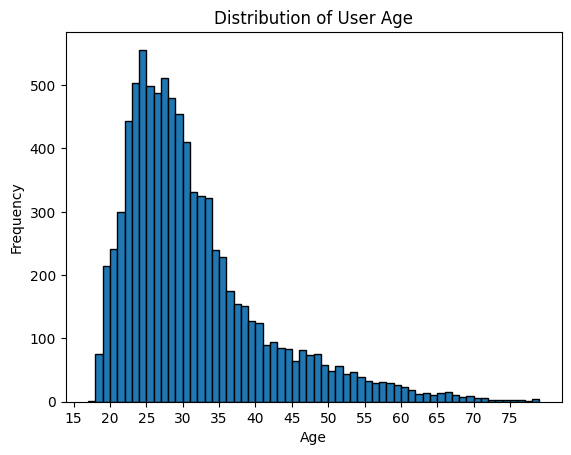

In [15]:
plt.hist(df_train['user_age'], bins=range(17, 80), edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of User Age')
plt.xticks(range(15, 80, 5))
plt.show()

In [16]:
df_train['user_age'].median()

28.0

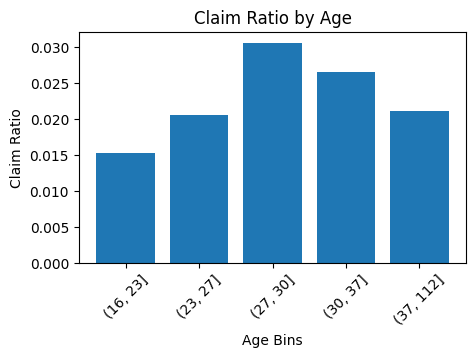

In [17]:
df_train['age_bin'], age_bins = pd.qcut(df_train['user_age'], q=5, precision=0, retbins=True)
age_bin_contingency_table = create_claimed_contingency_table('age_bin')
claim_ratio = age_bin_contingency_table['ratio']
claim_ratio.index = claim_ratio.index.astype(str).str.replace('\.0', '', regex=True)
plt.figure(figsize=(5, 3))
plt.bar(range(len(claim_ratio)), claim_ratio)
plt.xlabel('Age Bins')
plt.ylabel('Claim Ratio')
plt.title('Claim Ratio by Age')
plt.xticks(range(len(claim_ratio)), claim_ratio.index, rotation=45)
plt.show()

In [18]:
res = stats.chi2_contingency(age_bin_contingency_table[['claimed', 'unclaimed']])
res.statistic, res.pvalue

(10.139354602119145, 0.0381445701508395)

## credit_card

##### *Is card type correlative with claimed policies?* **Yes**  
Policies with different card types have different likelihood to be claimed. Chi-squared test Null hypothesis has been rejected (pvalue: 0.05).

In [19]:
card_type_contingency_table = create_claimed_contingency_table('card_type')
card_type_contingency_table

,total,claimed,unclaimed,ratio
card_type,,,,
credit,3552,65,3487,0.018300
debit,4944,129,4815,0.026092
prepaid,131,2,129,0.015267


In [20]:
res = stats.chi2_contingency(card_type_contingency_table[['claimed','unclaimed']], correction=False)
res.statistic, res.pvalue

(5.985926597753782, 0.05013864059141611)

## fire_housing_proximity + has_fire_alarm

Fire-housing proximity value is clipped at `4`, because there is not enough data for values 4+.  
No statistical difference between claimed/unclaimed ratios. Chi-squared test Null hypothesis has not been rejected (pvalue: 0.59).

In [21]:
df_train['fire_housing_proximity_clipped'] = df_train['fire_housing_proximity'].clip(upper=3)
fire_housing_contingency_table = df_train.groupby(['fire_housing_proximity_clipped', 'has_fire_alarm'], observed=True).agg(
    total=('filed_claim', 'count'), claimed=('filed_claim', 'sum')
)
fire_housing_contingency_table['unclaimed'] = fire_housing_contingency_table['total'] - fire_housing_contingency_table['claimed']
fire_housing_contingency_table['ratio'] = fire_housing_contingency_table['claimed'] / fire_housing_contingency_table['total']
fire_housing_contingency_table

total  claimed  unclaimed  \
fire_housing_proximity_clipped has_fire_alarm                              
1                              False             960       26        934   
                               True             3493       82       3411   
2                              False             656       14        642   
                               True             1839       36       1803   
3                              False             451       16        435   
                               True             1262       22       1240   

                                                  ratio  
fire_housing_proximity_clipped has_fire_alarm            
1                              False           0.027083  
                               True            0.023476  
2                              False           0.021341  
                               True            0.019576  
3                              False           0.035477  
                               True            0.017433

In [22]:
res = stats.chi2_contingency(fire_housing_contingency_table[['claimed','unclaimed']])
res.statistic, res.pvalue

(6.704975259111452, 0.24352235938902295)

## portable_electronics

Policies with coverage for portable electronics are more likely to be claimed.  
Interestingly, there is a very high correlation of missing value to `filed_claim`. The mechanism behind the missing value is not clear, but we might want to keep this indication.

In [23]:
df_train['portable_electronics_imputed'] = df_train['portable_electronics'].fillna('missing')
portable_electronics_contingency_table = create_claimed_contingency_table('portable_electronics_imputed')
portable_electronics_contingency_table

,total,claimed,unclaimed,ratio
portable_electronics_imputed,,,,
0.0,5577,109,5468,0.019545
1.0,2821,76,2745,0.026941
missing,263,11,252,0.041825


In [24]:
res = stats.chi2_contingency(portable_electronics_contingency_table[['claimed','unclaimed']])
res.statistic, res.pvalue

(9.151718558847387, 0.010297446990978416)

# Missing Data Analysis

#### Missing user_age

In [25]:
missing_user_age_count = df_train['user_age'].isnull().sum()
missing_portable_electronics_count = df_train['portable_electronics'].isnull().sum()
missing_user_age_and_portable_electronics_count = (df_train['portable_electronics'].isnull() & df_train['user_age'].isnull()).sum()

print(f"""
user_age missing values are correlated with portable_electronics missingness.
Overall user_age missing values: {missing_user_age_count} ({round(missing_user_age_count / len(df_train) * 100, 1)}% of total).
If portable_electronics is missing: 52 ({
    round(missing_user_age_and_portable_electronics_count / missing_portable_electronics_count * 100, 1)
    }% of {missing_portable_electronics_count} records with missing portable_electronics values).
""")


user_age missing values are correlated with portable_electronics missingness.
Overall user_age missing values: 49 (0.6% of total).
If portable_electronics is missing: 52 (11.8% of 263 records with missing portable_electronics values).



#### Missing coast

The `coast` field represents the distance from the coastline: varies from 0 (San Francisco) to 30 (Sacramento).  
Missing values are attributed to inland states.  
Impute the missing values with 30, which reflects the same coastline risk as the maximum value.

In [26]:
for coast, records in df_train[df_train.state == 'CA'].groupby('coast'):
    first = records.iloc[0]
    zipcode_info = df_uszips.loc[first.postal_code]
    print(f'{int(first.coast)}: {zipcode_info.city}')

0: San Francisco
1: San Francisco
2: San Pedro
3: Wilmington
4: Oakland
5: Oceanside
10: Los Angeles
15: Valley Village
20: Van Nuys
25: Lake Elsinore
30: Roseville


In [27]:
print("coast is null in inland states: " + ','.join(df_train[df_train.coast.isnull()].state.unique()))
print("coast is not null in states with coasts: " + ','.join(df_train[df_train.coast.notnull()].state.unique()))

coast is null in inland states: NM,AR,IA,AZ,DC,MI,NV,OH,PA
coast is not null in states with coasts: WI,RI,CT,IN,CA,DC,GA,IL,MD,NJ,NY,OR,PA,TX


### Summary and Imputation

- `card_type` - missing values cannot be attributed to any cause. Assuming MCAR missing mechanism. Impute with the most frequent value (`debit`).
- `coast` - missing values are attributed to inland states (see EDA) (MAR missing mechanism). Impute with `30`, which is the maximum value (most far from the coastline).
- `user_age` - missing values are correlated with `portable_electronics` missingness (see above), so there is an underline cause that is unknown and likely related to the data collection (MAR missing mechanism). Impute with median age.
- `portable_electronics` (see `user_age`) - since the missing value is more indicative of filing a claim, it will be imputed with value `1.0` which is also correlated with claim filing.
- `square_ft` - missing value highly correlated with `ho4` (renter) product (MAR missing mechanism). Dropping this feature, since 97.7% of the values are missing and the claim ratio of the remaining data is not statistically significant.

In [28]:
median_age = df_train['user_age'].median()

def impute_missing_data(_df):
    _df.fillna(
        {
            'card_type': 'debit',
            'coast': 30,
            'user_age': median_age,
            'portable_electronics': 1.0,
        },
        inplace=True,
    )

# Feature Engineering

## User Claim History

This could have been a great feature, but more data is required. The previously-claimed group is just too small.  

In [29]:
def prepare_previous_claims_feature(_df):
    previous_claims = 0
    prev_user_id = None
    for ix, row in _df.sort_values(['user_id', 'previous_policies']).iterrows():
        user_id = row['user_id']
        if prev_user_id != user_id:
            previous_claims = 0
            
        _df.loc[ix, 'previous_claims'] = previous_claims
        previous_claims += row['filed_claim']
        prev_user_id = user_id

prepare_previous_claims_feature(df_train)

In [30]:
previous_claims_contingency_table = create_claimed_contingency_table('previous_claims')
previous_claims_contingency_table

,total,claimed,unclaimed,ratio
previous_claims,,,,
0.0,8600,194,8406,0.022558
1.0,61,2,59,0.032787


## Claim ratio of nearest policies (by zipcode lat/lng)

This feature is the claim ratio of the nearest 40 policies.  
The feature is based on KNN - using the euclidean distances between policies as reflected from the lat/lng properties.  
The complex part is to exclude the user's polcicies for each policy candidate (to prevent data pollution).

In [31]:
from sklearn.neighbors import NearestNeighbors

NUM_NEIGHBORS = 40
MAX_USER_POLICIES = df_train['user_id'].value_counts().iloc[0]
knn_model = NearestNeighbors(n_neighbors=NUM_NEIGHBORS + MAX_USER_POLICIES, algorithm='auto')
knn_model.fit(df_train[['lat','lng']])

def predict_value(_df):
    # Find the indices of the nearest neighbors
    _, indices = knn_model.kneighbors(_df[['lat','lng']])

    # The policies of the same user are skipped, otherwise when the feature is built for the training data
    # it will be polluted with the self filed_claim value (or other claims of the same user).
    nearest_user_ids = df_train['user_id'].to_numpy()[indices]
    policies_mask = nearest_user_ids != _df['user_id'].to_numpy()[:, np.newaxis]
    valid_policy_indices = np.argwhere(policies_mask)
    indices_by_row = np.split(valid_policy_indices[:, 1], np.cumsum(np.unique(valid_policy_indices[:, 0], return_counts=True)[1])[:-1])
    selected_indices = [
        row_indices[:NUM_NEIGHBORS]
        for row_indices in indices_by_row
    ]
    
    # Get the corresponding values
    nearest_values = df_train['filed_claim'].to_numpy()[indices]
    selected_values = [nearest_values[i,row_indices] for i, row_indices in enumerate(selected_indices)]

    # Calculate the average value of the nearest neighbors
    predicted_value = np.mean(selected_values, axis=1)
    # return predicted_value
    return np.minimum(predicted_value, 0.025)

In [32]:
df_train['nearest_policies_claim_ratio'] = predict_value(df_train)
nearest_policies_claim_ratio = create_claimed_contingency_table('nearest_policies_claim_ratio')
nearest_policies_claim_ratio

,total,claimed,unclaimed,ratio
nearest_policies_claim_ratio,,,,
0.000,3573,69,3504,0.019312
0.025,5088,127,4961,0.024961


## Density

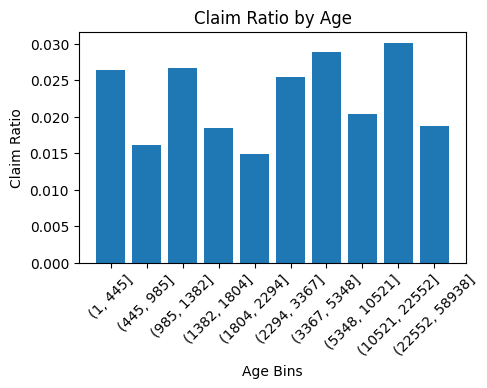

In [33]:
df_train['density_bin'], density_bins = pd.qcut(df_train['density'], q=10, precision=0, retbins=True)
density_bin_contingency_table = create_claimed_contingency_table('density_bin')
claim_ratio = density_bin_contingency_table['ratio']
claim_ratio.index = claim_ratio.index.astype(str).str.replace('\.0', '', regex=True)
plt.figure(figsize=(5, 3))
plt.bar(range(len(claim_ratio)), claim_ratio)
plt.xlabel('Age Bins')
plt.ylabel('Claim Ratio')
plt.title('Claim Ratio by Age')
plt.xticks(range(len(claim_ratio)), claim_ratio.index, rotation=45)
plt.show()

In [34]:
def is_rural(_df):
    return _df['density'] <= 445

df_train['is_rural'] = is_rural(df_train)
rural_contingency_table = create_claimed_contingency_table('is_rural')
rural_contingency_table

,total,claimed,unclaimed,ratio
is_rural,,,,
False,7795,173,7622,0.022194
True,866,23,843,0.026559


In [35]:
def is_urban(_df):
    return _df['density'] > 10521

df_train['is_urban'] = is_urban(df_train)
urban_contingency_table = create_claimed_contingency_table('is_urban')
urban_contingency_table

,total,claimed,unclaimed,ratio
is_urban,,,,
False,6928,154,6774,0.022229
True,1733,42,1691,0.024235


# Model

The model is based on XGBoost [[2]](#References) with a few enhancements over the baseline model:
- Increased number of estimators
- Regularization [[3]](#References):
    - Limit the XGBoost max depth to 2 (default is `6`)
    - Limit child weight (`min_child_weight`) to 30 (default is `1`)
- Imbalanced data adjustment: `scale_pos_weight` [[4]](#References)

In addition, some fine-tuning applied to the model features:
- `state` and `postal_code` are not included, because of their high cardinality. Instead, introduced features based on the enrichment of the zip code.
- `coast` is not included, because the model performs better without them.
- `square_ft` is not included since 97.7% of the values are missing and the claim ratio of the remaining data is not statistically significant.
- `policy_id` and `user_id` are not included for obvious reasons.

In [36]:
features = [
    'product',
    'age_bin',
    'card_type',
    'has_burglar_alarm',
    'fire_housing_proximity_clipped',
    'has_fire_alarm',
    'portable_electronics',
    'previous_policies',
    'is_rural',
    'is_urban',
    'nearest_policies_claim_ratio',
]

categorical_columns = [
    'product',
    'age_bin',
    'card_type',
]

def transform(_df):
    impute_missing_data(_df)

    # Apply the age bins
    _df['age_bin'] = pd.cut(_df['user_age'], bins=age_bins, include_lowest=True)

    # Clip the fire-housing proximity
    _df['fire_housing_proximity_clipped'] = _df['fire_housing_proximity'].clip(upper=3)

    # Add the previous claims feature
    prepare_previous_claims_feature(_df)

    # Add the density category features
    _df['is_rural'] = is_rural(_df)
    _df['is_urban'] = is_urban(_df)

    # Add the claim ratio of the nearest policies
    _df['nearest_policies_claim_ratio'] = predict_value(_df)
    
    for col in categorical_columns:
        _df[col] = _df[col].astype('category')
        _df[col].cat.set_categories(df_train[col].unique())
    return _df[features], _df['filed_claim']

X, y = transform(df_train)

In [37]:
label_value_counts = y.value_counts().tolist()
class_weight = label_value_counts[0] / label_value_counts[1] # the negative class is ~43 times more frequent than the positive class

classifier = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=2,
    min_child_weight=30,
    scale_pos_weight=class_weight,
    enable_categorical=True,
)

## Cross Validation Evaluation

We perform the model tuning based on the cross validation evaluation, thus we prevent overfitting against the test set.

In [38]:
kfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=42)
auc_scores = cross_val_score(classifier, X, y, cv=kfold, scoring='roc_auc')

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print("Mean AUC:", mean_auc)
print("Standard Deviation of AUC:", std_auc)

Mean AUC: 0.5832807105739823
Standard Deviation of AUC: 0.03270531969530914


## Train

In [39]:
classifier.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=30, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Test Set Evaluation

I have used the AUC score (Area Under the Curve) for evaluation because the dataset is highly imbalanced.  
At first, the model score looks low. Indeed for a given policy, it is hard to predict whether a claim will be filed.  

But from an insurer's perspective, any uplift above random is very useful.  
The model highest (risk) predictions are much more likely to file a claim.  
**The highest 10% predictions are 2 times more likely to file a claim than a random policy. This is extremely valuable for an insurer to correctly rate policies.**

In [40]:
X_test, y_test = transform(df_test)
predictions = classifier.predict_proba(X_test)

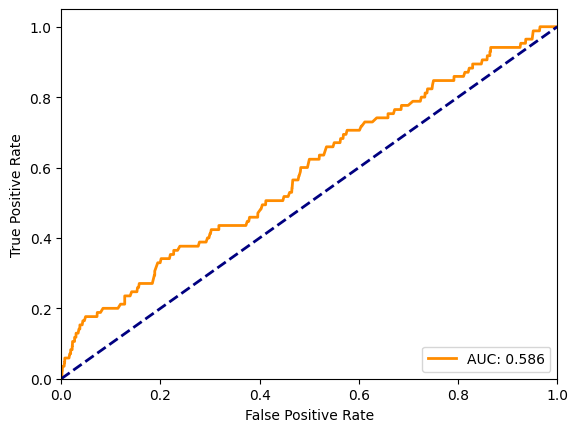

In [41]:
y_proba = predictions[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_proba)
auc = roc_auc_score(y_test, y_proba)

fig = plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange", lw=lw, label="AUC: %0.3f" % auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

### Model Prediction Uplift

In [42]:
baseline_claim_rate = np.mean(y_test)

def top_slice_claim_rate(s):
    decile_size = round(len(y_test) / s)  
    predicted_highest_risk_decile = sorted(list(zip(y_proba, y_test)))[-decile_size:]
    _, predicted_highest_risk_decile_labels = zip(*predicted_highest_risk_decile)
    return np.mean(predicted_highest_risk_decile_labels)

print(f"Baseline claim rate: {baseline_claim_rate:.3}")

top_quantile_claim_rate = top_slice_claim_rate(4)
top_quantile_uplift = top_quantile_claim_rate / baseline_claim_rate
print(f"Top quantile claim rate: {top_quantile_claim_rate:.3} (uplift: {top_quantile_uplift:.4})")
top_decile_claim_rate = top_slice_claim_rate(10)
top_decile_uplift = top_decile_claim_rate / baseline_claim_rate
print(f"Top decile claim rate: {top_decile_claim_rate:.3} (uplift: {top_decile_uplift:.4})")
top_percentile_claim_rate = top_slice_claim_rate(100)
top_percentile_uplift = top_percentile_claim_rate / baseline_claim_rate
print(f"Top percentile claim rate: {top_percentile_claim_rate:.3} (uplift: {top_percentile_uplift:.4})")

Baseline claim rate: 0.0228
Top quantile claim rate: 0.0343 (uplift: 1.506)
Top decile claim rate: 0.0455 (uplift: 1.998)
Top percentile claim rate: 0.135 (uplift: 5.94)


# Feature Importance

Following the shap analysis, the top features are age, claim-ratio of nearest policies, and the fire-housing proximity.  
Higher values of `nearest_policies_claim_ratio` and `portable_electronics`, or lower values of `previous_policies` and `has_fire_alarm`, are attributed to higher risk.  
Some categorical features are gray-colored (since red/blue colors are associated with +/-).  

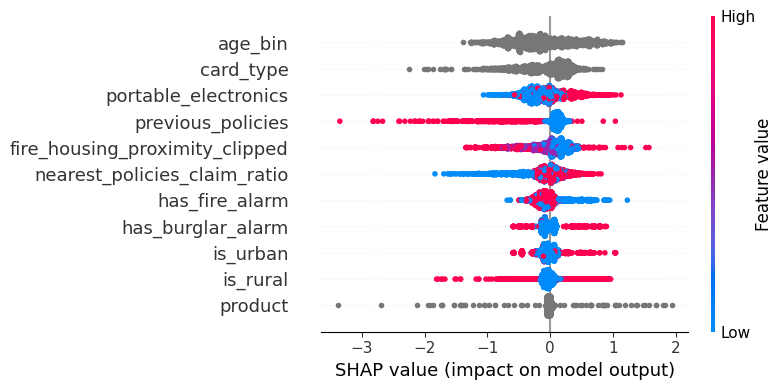

<Figure size 640x480 with 0 Axes>

In [43]:
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=classifier.feature_names_in_, plot_size=(8, 4))
plt.tight_layout()

# Error Analysis

Examined 3 positive samples with the lowest proba (most negative predictions), and also 3 negative samples with the highest proba (most positive predictions).  
This method helped me to understand better the reasoning behind the prediction errors.  
Two fixes were applied due to this analysis: one case of overfitted feature-bin, and another case of faulty feature processing.

#### Insights from the false negatives analysis (diagrams 1-3):
- Highest `fire_housing_proximity` (value: 3) significantly contributed to a predicted lower risk. This finding is surprising because `fire_housing_proximity` is a high risk indicator, but with a `has_fire_alarm=True` it's actually correlated with low risk (see EDA).
- As expected, significant contributors for a predicted low risk are lowest/highest age bins and the claim ratio of the nearest policies.

#### Insights from the false positives analysis (diagrams 4-6):
- Urban and portable-electroincs features are strong high risk indicators.
- As expected, certain age buckets contributed to a predicted high risk.

In [44]:
zipped_y = list(zip(range(len(y_test)), y_proba, y_test))
examined_positive_samples = sorted([(proba, iloc, 1) for iloc, proba, label in zipped_y if label==1])[:3]
examined_negative_samples = sorted([(proba, iloc, 0) for iloc, proba, label in zipped_y if label==0], reverse=True)[:3]
examined_samples = examined_positive_samples + examined_negative_samples

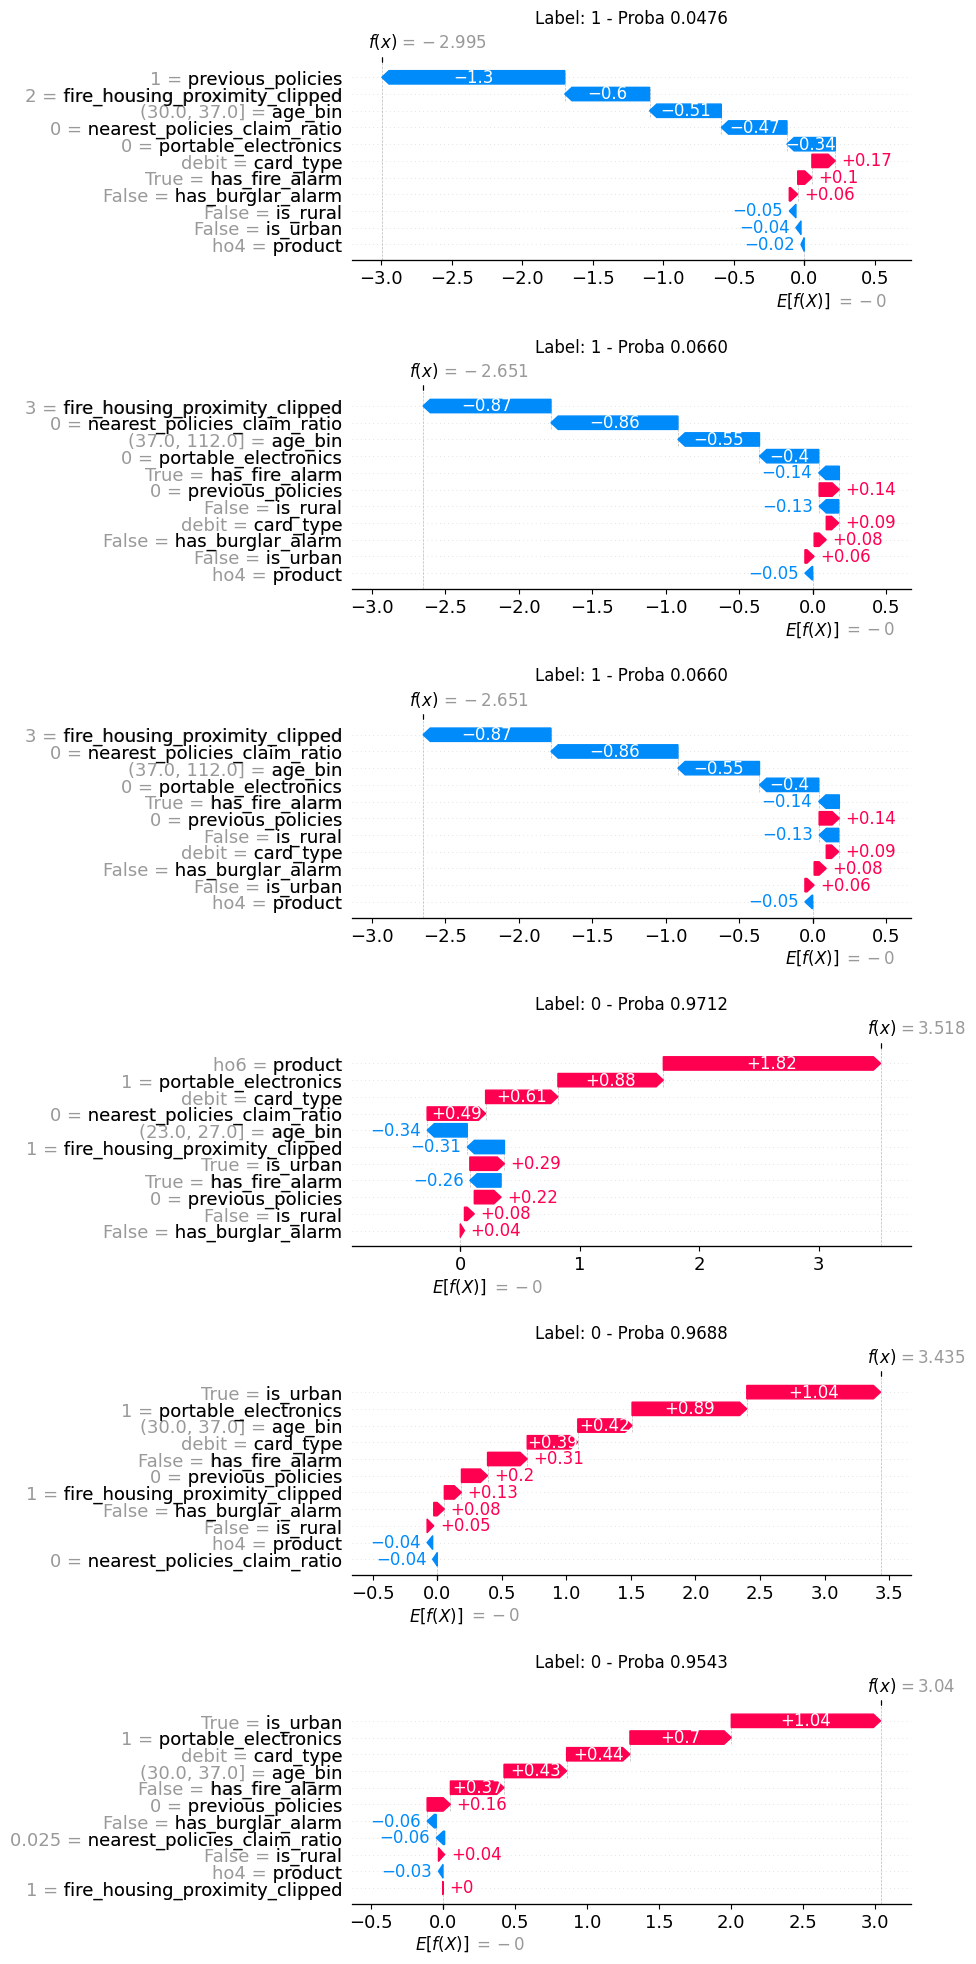

In [45]:
shap_values = explainer(X_test)
num_figs = len(examined_samples)
fig, axes = plt.subplots(num_figs, 1)

for i, (proba, iloc, label) in enumerate(examined_samples):
    plt.sca(axes[i])
    shap.plots.waterfall(shap_values[iloc], show=False, max_display=12)
    axes[i].set_title(f"Label: {label} - Proba {proba:.4f}")

fig.set_figheight(20)
fig.set_figwidth(10)
fig.tight_layout(pad=2.0)
plt.show()

# References

\[1\] [US Zip Codes Database](https://simplemaps.com/data/us-zips)

\[2\] [XGBClassifier API](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

\[3\] [XGBoost Control Overfitting](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#control-overfitting)

\[4\] [How to Configure XGBoost for Imbalanced Classification](https://machinelearningmastery.com/xgboost-for-imbalanced-classification/)
